In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/27-class-sign-language-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/27-class-sign-language-dataset/Y.npy
/kaggle/input/27-class-sign-language-dataset/X.npy


In [10]:
# Load features (images) and labels
X = np.load('/kaggle/input/27-class-sign-language-dataset/X.npy')
y = np.load('/kaggle/input/27-class-sign-language-dataset/Y.npy')

In [11]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [12]:
def resize_images(images, target_size=(128,128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

X_resized = resize_images(X)

In [13]:
images = X.astype('float32')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y.reshape(-1))
y_categorical = to_categorical(labels)

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  
    fill_mode='nearest'
)
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_categorical, test_size=0.2, random_state=42
)
# Create generator for training
train_generator = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True
)

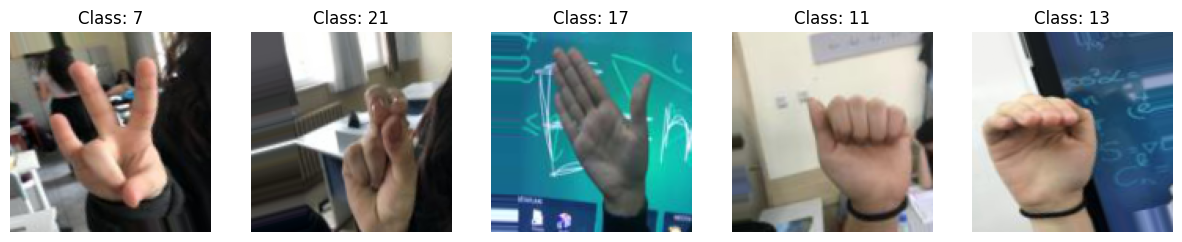

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(images, labels, num_samples=5, augmentation_type="Original"):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        
        # For grayscale images (single channel)
        if images[i].shape[-1] == 1:
            plt.imshow(images[i].squeeze(), cmap='gray')
        else:
            plt.imshow(images[i])
            
        plt.title(f"{augmentation_type}\nClass: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

# Generate a batch of augmented images
aug_images, aug_labels = next(train_generator)  # Correct syntax

# Plot samples
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    
    # For grayscale images (1 channel)
    if aug_images[i].shape[-1] == 1:
        plt.imshow(aug_images[i].squeeze(), cmap='gray')
    else:
        plt.imshow(aug_images[i])
    
    plt.title(f"Class: {np.argmax(aug_labels[i])}")
    plt.axis('off')
plt.show()

In [23]:
# Create a validation generator using ImageDataGenerator
val_datagen = ImageDataGenerator() # No augmentation 
val_generator = val_datagen.flow(
    x=X_val,
    y=y_val,
    batch_size=32,
    shuffle=False 
)

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [34]:
def build_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)  
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Get input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

# Build model
model, base_model = build_resnet50_model(input_shape, num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
]

history_top = model.fit(
    train_generator,
    epochs=15,  
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


# Evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f"\nFinal Validation Accuracy: {accuracy*100:.2f}%")


Epoch 1/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 151s 141ms/step - accuracy: 0.5007 - loss: 1.7280 - val_accuracy: 0.0254 - val_loss: 8.4041 - learning_rate: 1.0000e-04
Epoch 2/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 76s 132ms/step - accuracy: 0.9032 - loss: 0.3238 - val_accuracy: 0.9572 - val_loss: 0.1516 - learning_rate: 1.0000e-04
Epoch 3/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 78s 135ms/step - accuracy: 0.9381 - loss: 0.2033 - val_accuracy: 0.9546 - val_loss: 0.1787 - learning_rate: 1.0000e-04
Epoch 4/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 79s 137ms/step - accuracy: 0.9498 - loss: 0.1705 - val_accuracy: 0.9575 - val_loss: 0.1490 - learning_rate: 1.0000e-04
Epoch 5/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 79s 138ms/step - accuracy: 0.9612 - loss: 0.1395 - val_accuracy: 0.9774 - val_loss: 0.0965 - learning_rate: 1.0000e-04
Epoch 6/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 79s 138ms/step - accuracy: 0.9664 - loss: 0.1180 - val_accuracy: 0.9717 - val_loss: 0.1108 - learning_rate: 1.0000e-04
Epoch 7/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 1

/tmp/ipykernel_31/3538927122.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


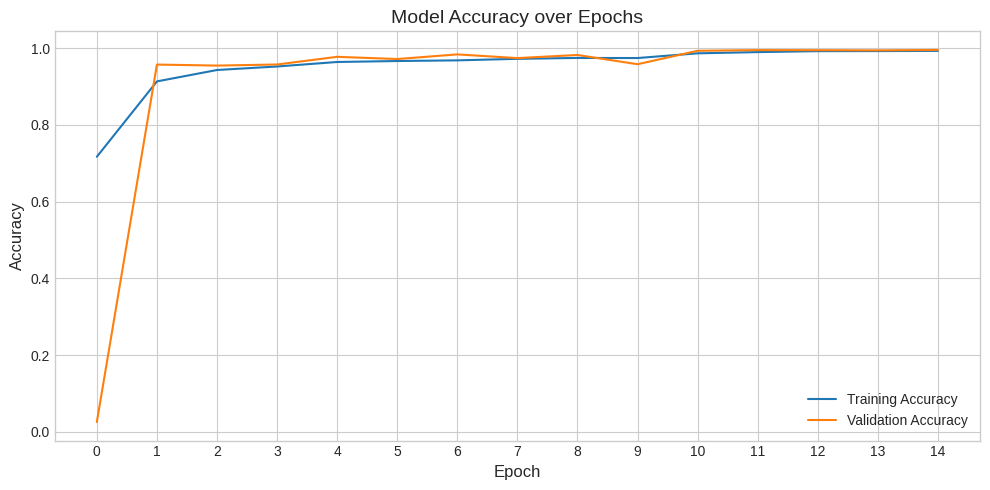

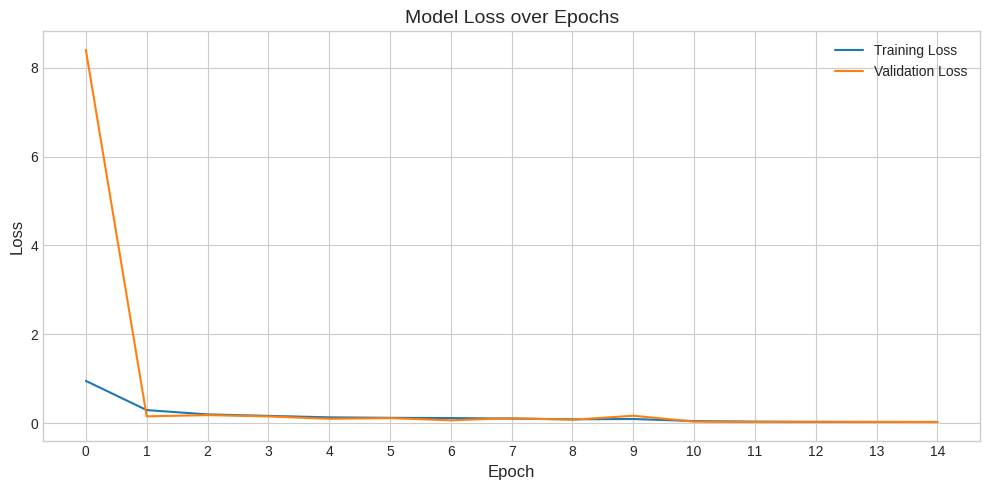

In [38]:
plt.style.use('seaborn-whitegrid')  

def plot_training_history(history):
    epochs = range(len(history.history['accuracy']))

    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(epochs)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(epochs)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history_top)
